In [2]:
import numpy as np
import pandas as pd
import glob

import scipy #scipy.spatial.Voronoi
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns

import itertools
import numpy
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot
%matplotlib inline


from shapely.geometry import LineString, MultiLineString, MultiPoint, Point, Polygon, box
from shapely.ops import nearest_points


I'm going to put in some effort to generate Proteomaps (voronoi treemaps). Sadly, these maps are not at all trivial to make. Specifically, it isn't obvious how to generate a Voronoi diagram where the size of each cell is proportional to some specified area. With that said, there do appear to be some tools in python (using QHull?) in Scipy that are able to do some of the required calculations to generate a Voronoi diagram. In addition, a paper from. Nocaj and Brandes 2012 suggests a way forward using an iterative approach. I came across this in a recent eLife paper where they generate Proteomaps based on this approach (https://elifesciences.org/articles/36842). Sadly, they do not provide any code. While I could ask them to share, it is unclear whether it will work with our python pipeline (which I think is important overall to our effort). 

Nocaj, A., & Brandes, U. (2012). Computing Voronoi Treemaps: Faster, Simpler, and Resolution‐independent. Computer Graphics Forum, 31(3pt1), 855–864. http://doi.org/10.1111/j.1467-8659.2012.03078.x

TO DOs:
In order to use the proposed algorithm, I need to be able to generate so-called power-weighted Voronoi diagram (also known as Laguerre-Voronoi diagram), which isn't what the Scipy tool does. I have found some code snippets at https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627 that provide some help and might enable me to make progress.

Using the algorithm from Nocaj, A., & Brandes, U. (2012), I need to generate power diagram, convert 
this into polygons, and iterate to get desired cell areas. 
1. Convert the cells into polygons (try using Shapely tool which will make calculating areas and centroids quite simple). Here I also need to intercect with our bounded polygon (i.e. the bounds of the figure)
2. Perform the adaptive weighting to recorrect positions of points, etc
3. iterate as needed - comparing desired volumes to current cell volumes. 

## Code to generate power diagram

In [105]:
# largely taken from
# https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627#file-laguerre-voronoi-2d-py
    
def norm2(X):
    return numpy.sqrt(numpy.sum(X ** 2))


def normalized(X):
    return X / norm2(X)


def get_power_triangulation(S, R):
    # Compute the lifted weighted points -NB: THIS IS THE IMPORTANT PART for the weighting
#     S_norm = numpy.sum(S ** 2, axis = 1) - R ** 2
    S_norm = numpy.sum(S ** 2, axis = 1) - np.array(R)# ** 2

    S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)

    # Special case for 3 points
    if S.shape[0] == 3:
        if is_ccw_triangle(S[0], S[1], S[2]):
            return [[0, 1, 2]], numpy.array([get_power_circumcenter(*S_lifted)])
        else:
            return [[0, 2, 1]], numpy.array([get_power_circumcenter(*S_lifted)])

    # Compute the convex hull of the lifted weighted points
    hull = ConvexHull(S_lifted)

    # Extract the Delaunay triangulation from the lower hull
#     tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
    tri_list = Delaunay(S_lifted,  qhull_options="QJ Pp")
    # Compute the Voronoi points
    V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])

    return tri_list, V


# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
    return normalized(np.cross(A, B) + np.cross(B, C) + np.cross(C, A))


def get_power_circumcenter(A, B, C):
    N = get_triangle_normal(A, B, C)
    return (-.5 / N[2]) * N[:2]

def is_ccw_triangle(A, B, C):
    M = numpy.concatenate([np.stack([A, B, C]), np.ones((3, 1))], axis = 1)
    return numpy.linalg.det(M) > 0


# --- Compute Voronoi cells ---------------------------------------------------


def get_voronoi_cells(S, V, tri_list):
    '''
    Compute the segments and half-lines that delimits each Voronoi cell
      * The segments are oriented so that they are in CCW order
      * Each cell is a list of (i, j), (A, U, tmin, tmax) where
         * i, j are the indices of two ends of the segment. Segments end points are
           the circumcenters. If i or j is set to None, then it's an infinite end
         * A is the origin of the segment
         * U is the direction of the segment, as a unit vector
         * tmin is the parameter for the left end of the segment. Can be None, for minus infinity
         * tmax is the parameter for the right end of the segment. Can be None, for infinity
         * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
    '''
    # Keep track of which circles are included in the triangulation
    vertices_set = frozenset(itertools.chain(*tri_list))

    # Keep track of which edge separate which triangles
    edge_map = { }
    for i, tri in enumerate(tri_list):
        for edge in itertools.combinations(tri, 2):
            edge = tuple(sorted(edge))
            if edge in edge_map:
                edge_map[edge].append(i)
            else:
                edge_map[edge] = [i]

    # For each triangle
    voronoi_cell_map = { i : [] for i in vertices_set }

    for i, (a, b, c) in enumerate(tri_list):
        # For each edge of the triangle
        for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
        # Finite Voronoi edge
            edge = tuple(sorted((u, v)))
            if len(edge_map[edge]) == 2:
                j, k = edge_map[edge]
                if k == i:
                    j, k = k, j
                
                # Compute the segment parameters
                U = V[k] - V[j]
                U_norm = norm2(U)

                # Add the segment
                voronoi_cell_map[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
            else: 
            # Infinite Voronoi edge
                # Compute the segment parameters
                A, B, C, D = S[u], S[v], S[w], V[i]
                U = normalized(B - A)
                I = A + numpy.dot(D - A, U) * U
                W = normalized(I - D)
                if numpy.dot(W, I - C) < 0:
                    W = -W
                    
                # Add the segment
                voronoi_cell_map[u].append(((edge_map[edge][0], np.inf), (D,  W, 0, np.inf)))
                voronoi_cell_map[v].append(((np.inf, edge_map[edge][0]), (D, -W, np.inf, 0)))



    # Order the segments
    def order_segment_list(segment_list):
        # Pick the first element
        first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

        # In-place ordering
        segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
        for i in range(len(segment_list) - 1):
            for j in range(i + 1, len(segment_list)):
                if segment_list[i][0][1] == segment_list[j][0][0]:
                    segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
                    break

        return segment_list

    return { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }




## Code to run iterator

In [6]:
def compute_power_voronoi_map(S, W,  eps, border):
    '''
    input: 
    S - Voronoi points/sites
    W - positive real weights associated with Voronoi points
    eps - for shapely conversion of lines to polygon - needed?
    border - bounds of desired map
    
    output:
    tri_list: Delaunay triangulation from the lower hull
    V_cell: Set of polygons forming all Voronoi cells
    
    '''
    # Compute the power triangulation of the circles
    tri_list, V = get_power_triangulation(S, W)

    # Compute the Voronoi cells
    voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

    # get the lines associated with all the Voronoi cells
    edge_map = { }
    for segment_list in voronoi_cell_map.values():
        for edge, (A, U, tmin, tmax) in segment_list:
            edge = tuple(sorted(edge))
            if edge not in edge_map:
                if tmax is np.inf:
                    tmax = 20
                if tmin is np.inf:
                    tmin = -20

                edge_map[edge] = (A + tmin * U, A + tmax * U)

    V_map = MultiLineString(list(edge_map.values())).buffer(eps)
    V_cell = border.difference(V_map)
    
    return tri_list, V_cell 

def AdaptPositionsWeights(S, V_cell, W):
    '''
    Use to shift Voronoi sites and adapt weights W 
    input: 
    V_cell - Set of polygons forming all Voronoi cells
    W - positive real weights associated with Voronoi points
    
    output:
    S_new: updated Voronoi points
    W_new: updates weights
    '''
    
    s = []
    dist_border = []
    for S in V_cell:
        for pp in S.centroid.coords: 
            s.append(pp) 
        dist_border.append(S.exterior.distance(Point(pp))) 

    S_new = np.array(list(map(list, s)))
    W_new = [np.min([np.sqrt(W[i]),dist_border[i]])**2 for i in np.arange(len(W))]
    return S_new, W_new 



def AdaptWeights(V_cell, S, bound, W, w_desired, err = 0.001):
    '''
    Use to adapt weights W
    input: 
    V_cell - Set of polygons forming all Voronoi cells
    S - Voronoi points
    W - positive real weights associated with Voronoi points
    w_desired - desired weighting of each cell
    err - error threshold for values in W; need to understand better.
    
    output:
    W_new: updates weights
    '''
    W_new = []
    
    for i, s in enumerate(S):
        s_other = [tuple(s_) for s_ in S if tuple(s_) != tuple(s)]
        NN = nearest_points(Point(s),MultiPoint(s_other))
        
        A_current = V_cell[i].area
        A_desired = bound.area * w_desired[i]
        
        f_adapt = A_desired / A_current
         
        w_new_ = np.sqrt(W[i]) * f_adapt  
#         w_new_ = W[i] * f_adapt  
        w_max = (LineString(NN).length)

        W_ = np.min([w_new_, w_max])**2
        W_new.append(np.max([W_, err]))
        
    return W_new

# selection of random initialization points
def disc_uniform_pick(N):
    angle = (2 * numpy.pi) * numpy.random.random(N)
    out = numpy.stack([numpy.cos(angle), numpy.sin(angle)], axis = 1)
    out *= numpy.sqrt(numpy.random.random(N))[:,None]
    return out

In [107]:

# initialize random Voronoi sites and weightings
# S contains circles center, R contains circles radius for weighting the Voronoi cells
sample_count = 10
S = 5 * disc_uniform_pick(sample_count)
W = .8 * numpy.random.random(sample_count) + .2

## initialize Laguerre-Voronoi diagram
tri_list, V = get_power_triangulation(S, W)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

eps = 0.0001
weights = np.ones(sample_count)* 0.2
weights[:5] = 0.25
weights[5:] = 1
weights =weights/ np.sum(weights)

# border
b_s = 10
border = box(-b_s, -b_s, b_s, b_s)
err_thresh = 0.1

In [108]:
tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)

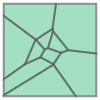

In [27]:
V_cell

In [36]:
# Perform iteration on initialized V_cell
for i in np.arange(20):
    print(i)
    S, W = AdaptPositionsWeights(V_cell, W)

    tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)
    
    W = AdaptWeights(V_cell, S, border, W, weights)
    
    tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)
    
    # calculate discrepency between desired cell area and
    # current cell area.
    # I don't understand the error function in Nocaj, A., & Brandes, U. (2012),
    # so this needs some work
    A_diff = 0
    for i, cell in enumerate(V_cell):
        A_diff += abs(cell.area - border.area * weights[i])
    error_calc =  A_diff/(2*border.area)

    print(error_calc)


0
0.2255285912708748
1
0.1558468904071052
2
0.15850677350993458
3
0.10115983028314464
4
0.09500574736744005
5
0.08926626500355692
6
0.08432831921058065
7
0.08324736781555817
8
0.08217674954385988
9
0.08077142403902947
10
0.18044514924960908
11
0.13813135245802458
12
0.17961445382583707
13
0.18531681942651992
14
0.17549090442380164
15
0.22273651692047086
16
0.15758267683124244
17
0.1614293875767353
18
0.10108193406735723
19
0.09530545995560104


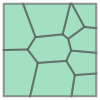

In [38]:
# take a look at diagram, i.e. V_cell
V_cell

## Treemap structure

Okay, progress! It looks like the algorithm. is roughly working. I don't think I'm applying it exactly as outlines, so it'll still need some work. I also find that if I begin with e.g. only 5 points, the number of cells will drop to less than 5 as the iterations proceed. It looks like certain lines are lost, but I'm not really sure why. 

In any case, lets next try to build a treemap structure that takes in the different proteome sector categories and determines the weightings based on protein abundance. This will be a multi-level structure: we will begin with our main plot bounds (i.e. square box) and generate cells with the higher-level categories; Each cell will then become a new set of bounds to build another set of cells that will house lower-level categories (or individual proteins). I suspect we will want to build seperate diagrams for each lower-level category (where will be the place to show individual genes).

There are only 5 'cog_class' categories and given the weird behavior I'm seeing for only 5 cells,  lets begin with the 'cog_class' categories (I may be able to join them by putting items from same 'cog_class' next to each other.

In [7]:
# Load the dataset with aboslute measurements
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')

In [8]:
data.head()

,gene_name,b_number,condition,go_terms,cog_class,cog_category,cog_letter,growth_rate_hr,gene_product,tot_per_cell,fg_per_cell,dataset,dataset_name,strain
0,InsH-1,b0259,lb_miller,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.90,CP4-6 prophage; IS5 transposase and trans-acti...,176.675627,0.011534,schmidt_2016,Schmidt et al. 2016,BW25113
1,InsH-1,b0259,glycerol_pAA,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,1.27,CP4-6 prophage; IS5 transposase and trans-acti...,101.424400,0.006621,schmidt_2016,Schmidt et al. 2016,BW25113
2,InsH-1,b0259,acetate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.30,CP4-6 prophage; IS5 transposase and trans-acti...,21.374427,0.001395,schmidt_2016,Schmidt et al. 2016,BW25113
3,InsH-1,b0259,fumarate,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.42,CP4-6 prophage; IS5 transposase and trans-acti...,64.846091,0.004233,schmidt_2016,Schmidt et al. 2016,BW25113
4,InsH-1,b0259,galactose,GO:0005829; GO:0032196; GO:0006313; GO:0006310...,cellular processes and signaling,"mobilome: prophages, transposons",X,0.26,CP4-6 prophage; IS5 transposase and trans-acti...,46.647597,0.003045,schmidt_2016,Schmidt et al. 2016,BW25113


In [9]:
frac = pd.DataFrame()

# generate desired area weightings
for cog, d in data.groupby('cog_category'):
    frac_ = d.fg_per_cell.sum()/ data.fg_per_cell.sum()
    frac = frac.append({'mass_frac':frac_,
                       'cof_category': cog}, ignore_index=True )

In [106]:
# initialize random Voronoi sites and weightings
# S contains circles center, R contains circles radius for weighting the Voronoi cells
sample_count = len(frac)
S = 5 * disc_uniform_pick(sample_count)
W = .8 * numpy.random.random(sample_count) + .2

## initialize Laguerre-Voronoi diagram
tri_list, V = get_power_triangulation(S, W)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

eps = 0.0000001
weights = frac.mass_frac.values

# border
b_s = 15
border = box(-b_s, -b_s, b_s, b_s)
# err_thresh = 0.1

TypeError: 'Delaunay' object is not iterable

In [94]:
tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)

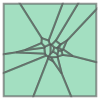

In [96]:
V_cell

In [98]:
# look at error in cell area to begin
for i, cell in enumerate(V_cell):
    print(cell.area/(border.area * weights[i]))

8.476940586360639
1311.237649371272
5.260721260590689
0.4235601352861916
1.0069053742593208
31.577278683847954
123.98096859557947
1.6455486140376188
7.963372376033635
0.48316617372985177
0.00719420690198998
6856.248835117267
0.38542548546092276
0.34210515753113785
0.08904343513840682
0.5093403709236317
0.2774439606097476
16.298306728363556
0.03258834455988123
0.04967837239530143
0.4225049637729609
0.5137006424496094
0.1921626974561006
0.020892943068219535


In [99]:
# Perform iteration on initialized V_cell
for i in np.arange(100):
#     print(i)
    S, W = AdaptPositionsWeights(S, V_cell, W)

    tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)
    
    W = AdaptWeights(V_cell, S, border, W, weights, err = 1E-5)
    
    tri_list, V_cell = compute_power_voronoi_map(S, W, eps, border)
    print(len(tri_list))
    # calculate discrepency between desired cell area and
    # current cell area.
    # I don't understand the error function in Nocaj, A., & Brandes, U. (2012),
    # so this needs some work
    A_diff = 0
    for i, cell in enumerate(V_cell):
        A_diff += abs(cell.area - border.area * weights[i])
    error_calc =  A_diff/(2*border.area)

    print(error_calc)



38
0.6086586288211975
38
0.5749862032407951
38
0.5421940585984487
38
0.49567212185485976
38
0.4378026870495547
39
0.3616617493098948
38
0.38730454833003536
39
0.3426350960731402
38
0.3192265279176344
38
0.5680196458050016
38
0.45296046541552376
37
0.35180532344229504
38
0.3230297978934005
38
0.516106454028137
38
0.5176907009898774
37
0.4423089609777206
37
0.5239056014137268
37
0.45664932487355303
37
0.5656610410196142
36
0.5196766383112441
38
0.4964588133944619


IndexError: index out of range

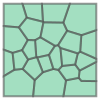

In [100]:
V_cell

In [101]:
#look at error
for i, cell in enumerate(V_cell):
    print(cell.area/(border.area * weights[i]))

3.45154124810209
326.7178633374047
1.9202635031001087
0.34167879619144603
1.0074797014763615
10.38921765169598
73.57747519875235
0.6622234686792836
4.858308244611211
1.73921165509252
0.49493204349318515
85292.9204242636
4.418928137473538
2.750358402152635
0.7271449158485991
6.49888886332589
1.6581520015701896
1133.4860759823007
0.8869692484071722
0.506593612520435
6.5233421953982305
1.1705598301799653
1.3547242516263338


In [ ]:
# np.set_printoptions(suppress=True)

## original example to troubleshoot

In [85]:
def disc_uniform_pick(N):
	angle = (2 * numpy.pi) * numpy.random.random(N)
	out = numpy.stack([numpy.cos(angle), numpy.sin(angle)], axis = 1)
	out *= numpy.sqrt(numpy.random.random(N))[:,None]
	return out



def norm2(X):
	return numpy.sqrt(numpy.sum(X ** 2))



def normalized(X):
	return X / norm2(X)



def get_circumcenter(A, B, C):
	U, V = B - A, C - A
	U_norm, V_norm = norm2(U), norm2(V)
	U /= U_norm
	V /= V_norm
	UdV = numpy.dot(U, V)

	D = numpy.array([U_norm - UdV * V_norm, V_norm - UdV * U_norm])
	D /= 2. * (1. - UdV ** 2) 

	center = D[0] * U + D[1] * V

	return A + center


def display(S, tri_list, voronoi_cell_list):
	# Setup
	fig, ax = plot.subplots()
	plot.axis('equal')
	plot.axis('off')	

	# Plot the samples
	plot.scatter(S[:,0], S[:,1], lw = 0., c = 'k', zorder = 1)

	# Plot the Delaunay triangulation
	edge_set = frozenset(tuple(sorted(edge)) for tri in tri_list for edge in itertools.combinations(tri, 2))
	line_list = LineCollection([(S[i], S[j]) for i, j in edge_set], lw = 1., colors = '.8')
	line_list.set_zorder(0)
	ax.add_collection(line_list)

	# Plot the Voronoi cells
	edge_map = { }
	for segment_list in voronoi_cell_list:
		for edge, (A, U, tmin, tmax) in segment_list:
			edge = tuple(sorted(edge))
			if edge not in edge_map:
				if tmax is None:
					tmax = 20
				if tmin is None:
					tmin = -20

				edge_map[edge] = (A + tmin * U, A + tmax * U)

	line_list = LineCollection(edge_map.values(), lw = 1., colors = 'k')
	line_list.set_zorder(0)
	ax.add_collection(line_list)

	# Job done
	plot.show()

def is_ccw_triangle(A, B, C):
	M = numpy.concatenate([numpy.stack([A, B, C]), numpy.ones((3, 1))], axis = 1)
	return numpy.linalg.det(M) > 0



def get_delaunay_triangulation(S):
	# Special case for 3 points
	if S.shape[0] == 3:
		if is_ccw_triangle(S[0], S[1], S[2]):
			return [[0, 1, 2]]
		else:
			return [[0, 2, 1]]

	# Compute the lifted points
	S_norm = numpy.sum(S ** 2, axis = 1) - R**2
	S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)

	# Compute the convex hull of the lifted points
	hull = ConvexHull(S_lifted)
	
	# Extract the Delaunay triangulation from the lower hull, all triangles are ccw
	return tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b] for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)

def get_voronoi_cells(S, tri_list):
	# Compute the circumcenter of each Delaunay triangle
	V = numpy.array([get_circumcenter(*S[tri]) for tri in tri_list])

	# Keep track of which edge separate which triangles
	edge_map = { }
	for i, tri in enumerate(tri_list):
		for edge in itertools.combinations(tri, 2):
			edge = tuple(sorted(edge))
			if edge in edge_map:
				edge_map[edge].append(i)
			else:
				edge_map[edge] = [i]

	# For each triangle
	voronoi_cell_list = [[] for i in range(S.shape[0])]

	for i, (a, b, c) in enumerate(tri_list):
		# For each edge of the triangle
		for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
			edge = tuple(sorted((u, v)))

			# Finite Voronoi edge
			if len(edge_map[edge]) == 2:
				j, k = edge_map[edge]
				if k == i:
					j, k = k, j
				
				# Compute the segment [Vj, Vk] parameters
				U = V[k] - V[j]
				U_norm = norm2(U)				

				# Add the segment
				voronoi_cell_list[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
			else: 
			# Infinite Voronoi edge
				# Compute the segment parameters
				A, B, C, D = S[u], S[v], S[w], V[i]
				U = normalized(B - A)
				I = A + numpy.dot(D - A, U) * U
				W = normalized(I - D)
				if numpy.dot(W, I - C) < 0:
					W = -W	
			
				# Add the segment
				voronoi_cell_list[u].append(((edge_map[edge][0], None), (D,  W, 0, None)))				
				voronoi_cell_list[v].append(((None, edge_map[edge][0]), (D, -W, None, 0)))				

	# Order in-place the segments in ccw order
	def order_segment_list(segment_list):
		if len(segment_list) > 0:
			# Pick the first element
			first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

			# In-place ordering
			segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
			for i in range(len(segment_list) - 1):
				for j in range(i + 1, len(segment_list)):
					if segment_list[i][0][1] == segment_list[j][0][0]:
						segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
						break

		# Job done
		return segment_list
    
	return [order_segment_list(segment_list) for segment_list in voronoi_cell_list], voronoi_cell_list


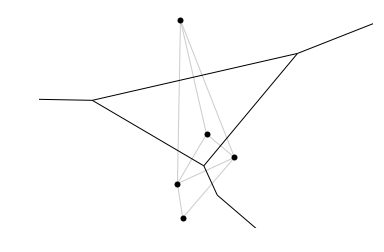

In [88]:
# Generate samples
S = 10. * disc_uniform_pick(5)
R = .8 * numpy.random.random(len(S)) + .2

# Compute the Delaunay triangulation of the points
tri_list = get_delaunay_triangulation(S)

# Compute the Voronoi cells
voronoi_cell_list, voronoi_cell_list_ = get_voronoi_cells(S, tri_list)

# Display the result
display(S, tri_list, voronoi_cell_list)

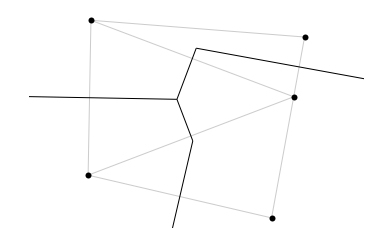

In [115]:
# Generate samples
S = 10. * disc_uniform_pick(5)
R = .8 * numpy.random.random(len(S)) + .2

# Compute the lifted points
S_norm = numpy.sum(S ** 2, axis = 1) - R**2
S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)

# Compute the convex hull of the lifted points
hull = ConvexHull(S_lifted)

# tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b] for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)
tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b] for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)


# Compute the Voronoi cells
voronoi_cell_list, voronoi_cell_list_ = get_voronoi_cells(S, tri_list)

# Display the result
display(S, tri_list, voronoi_cell_list)

# for simplex in hull.simplices:
#     plt.plot(S[simplex, 0], S[simplex, 1], 'k-')



In [ ]:
# I'm really not sure why the convex hull misses some of these lines -
# but perhaps I can identify them and generate them 
# for example, here I can check which lines from the triangulation lack a line crossing it, and plot perpendicular

# steps: (maybe?)
# 1. generate polygons
# check which polygons contain >=2 points (assume 2 at most for now)
# find perpindicular line, centered between these points
# split polygon using this line.

In [116]:
hull.simplices

array([[3, 2, 1],
       [3, 2, 0],
       [4, 2, 1],
       [4, 2, 0],
       [4, 3, 1],
       [4, 3, 0]], dtype=int32)

In [117]:
tri_list

([3, 1, 2], [4, 1, 3], [4, 3, 0])

In [11]:

def is_ccw_triangle(A, B, C):
	M = numpy.concatenate([numpy.stack([A, B, C]), numpy.ones((3, 1))], axis = 1)
	return numpy.linalg.det(M) > 0



def get_delaunay_triangulation(S):
	# Special case for 3 points
	if S.shape[0] == 3:
		if is_ccw_triangle(S[0], S[1], S[2]):
			return [[0, 1, 2]]
		else:
			return [[0, 2, 1]]

	# Compute the lifted points
	S_norm = numpy.sum(S ** 2, axis = 1)
	S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)

	# Compute the convex hull of the lifted points
	hull = ConvexHull(S_lifted)
	
	# Extract the Delaunay triangulation from the lower hull, all triangles are ccw
	return tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b] for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)

